# Local Quadratic and Cubic Regression
Spring 2019 AME-70790 Final Project

Nicholas Geneva (ngeneva@nd.edu)

Reference: Wand, M. P., & Jones, M. C. (1994). Kernel smoothing. Chapman and Hall/CRC.
___
In the previous example we looked at the general formulation of local polynomial estimators but only implemented a local linear regression. 
In this example we will take a look at implementing higher order polynomials. Just like the previous example, for our regression problem we will consider the following function:
    $$m(x)=2\exp\left\{-x^{2}/(0.3)^{2}\right\}+3\exp\left\{-(x-1)^{2}/(0.7)^{2}\right\}, \quad x\in[0,1],$$
with output-wise noise added to each observation:
    $$y_{i}=m(x_{i})+0.075\epsilon_{i},\quad \epsilon_{i}\sim\mathcal{N}(0,1).$$

#### Local Quadratic Regression
Recall the general formulation of local polynomial estimators:
    $$\mathcal{L} = \sum_{i=1}^{n}\left(y_{i}-\sum_{j=0}^{p}\beta_{j}(x_{i}-x)^{j}\right)^{2}K_{h}(x_{i}-x),$$
where $\beta$ are the learnable parameters that represent local Taylor expansion coefficients. 
The formulation for local quadratic regression is found by simply taking $p=2$ (recall the local linear regression is when $p=1$):
    $$\mathcal{L} = \sum_{i=1}^{n}\left(y_{i}-\beta_{0} + \beta_{1}(x_{i}-x) + \beta_{2}(x_{i}-x)^{2}\right)^{2}K_{h}(x_{i}-x).$$
Again we will simply use the  normal distribution as the kernel function $K_{h}=\mathcal{N}(0,h^{2})$.
We will lower the bandwidth so we can see the effects of using higher order polynomials on the local regression predictions.

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
plt.close("all")
np.random.seed(123)
ntrain = 100 # Number of training points
h = 0.025 # Kernel Bandwidth

# Generate training data
x_train = np.linspace(0,1,ntrain)
Y = 2*np.exp(-x_train**2/(0.3**2)) + 3*np.exp(-(x_train-1)**2/(0.7**2)) + 0.075*np.random.randn(ntrain)

# Predict
n_pred = 100
x_pred = np.linspace(0,1,n_pred)
y_pred = np.zeros(n_pred)
betas = np.zeros((n_pred, 3))
for i, x0 in enumerate(x_pred):
    # Solve for betas
    X = np.stack([np.ones(ntrain), x_train-x0, (x_train-x0)**2], axis=1)
    W = np.diag(norm.pdf(x_train-x0, loc=0, scale=h))
    betas[i] = np.linalg.inv(X.T.dot(W).dot(X)).dot(X.T).dot(W).dot(Y)

Something to recognize is that although we are giving the model more freedom with higher order polynomials, this comes at the cost of more computation.
Considering that we must compute a regression at each prediction point, extending to higher polynomial orders does not have the same effect as traditional regression.
Depending on the amount and smoothness of the data, there may be no significant gain of using higher order methods over a local linear model.

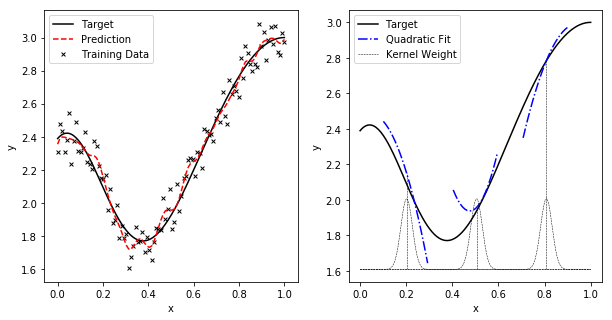

In [3]:
fig = plt.figure(figsize=(10,5))
ax = []
ax.append(plt.subplot2grid((1, 2), (0, 0)))
ax.append(plt.subplot2grid((1, 2), (0, 1)))

# Plot target
x_target = np.linspace(0,1,200)
y_target = 2*np.exp(-x_target**2/(0.3**2)) + 3*np.exp(-(x_target-1)**2/(0.7**2))
ax[0].plot(x_target, y_target, '-', color='k', label='Target')

# Plot training data
ax[0].scatter(x_train, Y, c='k', s=15.0, marker='x', linewidth=1.0, label='Training Data', alpha=0.5)

# Plot local linear kernel estimate
# Recall that the prediction at each point is simply the intercept value beta0
ax[0].plot(x_pred, betas[:,0], '--', color='r', label='Prediction')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].legend()

# Plot several local cubic fits
p1, = ax[1].plot(x_target, y_target, '-', color='k', label='Target')
idxs = [int(n_pred/5), int(n_pred/2), int(4*n_pred/5)]
for i, idx in enumerate(idxs):
    x_cen = x_pred[idx]
    x_loc = x_pred[idx-int(n_pred/10):idx+int(n_pred/10)]
    y_loc = betas[idx,0]+betas[idx,1]*(x_loc - x_cen) + betas[idx,2]*(x_loc - x_cen)**2
    p2, = ax[1].plot(x_loc, y_loc, '-.', color='b')
    p3, = ax[1].plot(x_target, 0.025*norm.pdf(x_target-x_cen, loc=0, scale=h)+np.min(Y), '--', color='k', linewidth=0.5)
    ax[1].plot([x_cen,x_cen], [np.min(Y), betas[idx,0]], '--', color='k', linewidth=0.5) # center line

ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].legend((p1,p2,p3),('Target', 'Quadratic Fit', 'Kernel Weight'))
plt.show()

The left shows the local cubic estimator's prediction and the right three local cubic fits at three specific datums.
The prediction appears to be relatively noisy due to the lower band-width selection, however we are able to clear see the local quadratic polynomials.

#### Local Cubic Regression
For local cubic regression $p=2$:
    $$\mathcal{L} = \sum_{i=1}^{n}\left(y_{i}-\beta_{0} + \beta_{1}(x_{i}-x) + \beta_{2}(x_{i}-x)^{2} + \beta_{3}(x_{i}-x)^{3}\right)^{2}K_{h}(x_{i}-x),$$
where the kernel function is $K_{h}=\mathcal{N}(0,h^{2})$.

In [4]:
# Predict
y_pred = np.zeros(n_pred)
betas = np.zeros((n_pred, 4))
for i, x0 in enumerate(x_pred):
    # Solve for betas
    X = np.stack([np.ones(ntrain), x_train-x0, (x_train-x0)**2, (x_train-x0)**3], axis=1)
    W = np.diag(norm.pdf(x_train-x0, loc=0, scale=h))
    betas[i] = np.linalg.inv(X.T.dot(W).dot(X)).dot(X.T).dot(W).dot(Y)

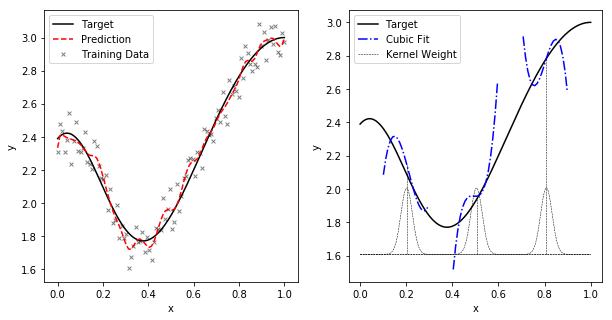

In [6]:
fig = plt.figure(figsize=(10,5))
ax = []
ax.append(plt.subplot2grid((1, 2), (0, 0)))
ax.append(plt.subplot2grid((1, 2), (0, 1)))

# Plot target
x_target = np.linspace(0,1,200)
y_target = 2*np.exp(-x_target**2/(0.3**2)) + 3*np.exp(-(x_target-1)**2/(0.7**2))
ax[0].plot(x_target, y_target, '-', color='k', label='Target')

# Plot training data
ax[0].scatter(x_train, Y, c='k', s=15.0, marker='x', linewidth=1.0, label='Training Data', alpha=0.5)

# Plot local linear kernel estimate
# Recall that the prediction at each point is simply the intercept value beta0
ax[0].plot(x_pred, betas[:,0], '--', color='r', label='Prediction')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].legend()

# Plot several local cubic fits
p1, = ax[1].plot(x_target, y_target, '-', color='k', label='Target')
idxs = [int(n_pred/5), int(n_pred/2), int(4*n_pred/5)]
for i, idx in enumerate(idxs):
    x_cen = x_pred[idx]
    x_loc = x_pred[idx-int(n_pred/10):idx+int(n_pred/10)]
    y_loc = betas[idx,0]+betas[idx,1]*(x_loc - x_cen) + betas[idx,2]*(x_loc - x_cen)**2 +\
        betas[idx,3]*(x_loc - x_cen)**3
    p2, = ax[1].plot(x_loc, y_loc, '-.', color='b')
    p3, = ax[1].plot(x_target, 0.025*norm.pdf(x_target-x_cen, loc=0, scale=h)+np.min(Y), '--', color='k', linewidth=0.5)
    ax[1].plot([x_cen,x_cen], [np.min(Y), betas[idx,0]], '--', color='k', linewidth=0.5) # center line

ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].legend((p1,p2,p3),('Target', 'Cubic Fit', 'Kernel Weight'))
plt.show()

The left shows the local cubic estimator's prediction and the right three local cubic fits at three specific datums.
Just from a qualitative view point there doesn't appear to be any significant advantage of higher order polynomials for the particular function since it is relatively smooth.
Additionally, if the bandwidth is increased the predictions will become more smoothed resulting in even the local fits between polynomial orders being indistinguishable. 